# An introduction to supervised learning using scikit-learn
*Maximilian Kasy, 2024*


This tutorial is partially based on Chapter 5 of [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake VanderPlas.  
You can find compehensive documentation of `scikit-learn` at [https://scikit-learn.org](https://scikit-learn.org).

Load standard packages for numerical calculations and for plotting:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Load functions from scikit-learn, a well-developed package for classic machine learning:

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, validation_curve, GridSearchCV

from sklearn.preprocessing import SplineTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso

## A motivating example: Digit recognition

Load example dataset:

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

The images data is a three-dimensional array: 1,797 samples each consisting of an 8 × 8 grid of pixels.

Visualize the first hundred of these:

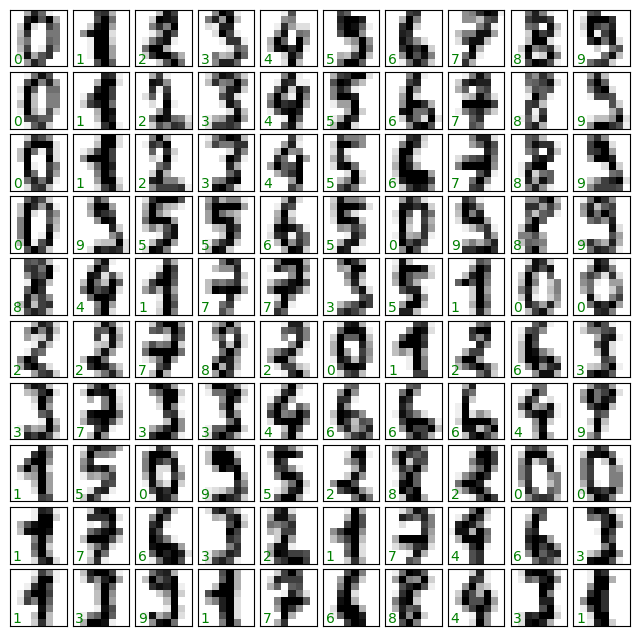

In [4]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

`scikit-learn` requires a two-dimensional, `[n_samples, n_features]` representation.

Such a representation is already available in the example dataset (treating each pixel as a component of `X`):

In [5]:
X = digits.data
X.shape

(1797, 64)

In [6]:
y = digits.target
y.shape

(1797,)

## Basic recipe for fitting a supervised learning model

1. Choose a class of model.
2. Choose model hyperparameters.
3. Fit the model to the training data.
4. Use the model to predict labels for new data.

Split the dataset into training data and test data (for model validation):

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

Choos1 a class of model (Gaussian naive Bayes, for this example):

In [8]:
model = GaussianNB()

Fit the model to the training data:

In [9]:
model.fit(Xtrain, ytrain)

GaussianNB()

Predict outcomes for the test data:

In [10]:
y_predicted_test = model.predict(Xtest)

Assess model accuracy, by comparing the true values of the test set to the predictions:

In [11]:
accuracy_score(ytest, y_predicted_test)

0.8333333333333334

We get 83% accuracy for classification of the digits!

The *confusion matrix* tells us where the predictions went wrong, for discrete outcomes:

In [12]:
mat = confusion_matrix(ytest, y_predicted_test)

Plot the confusion matrix using a heatmap (from the Seaborn package):

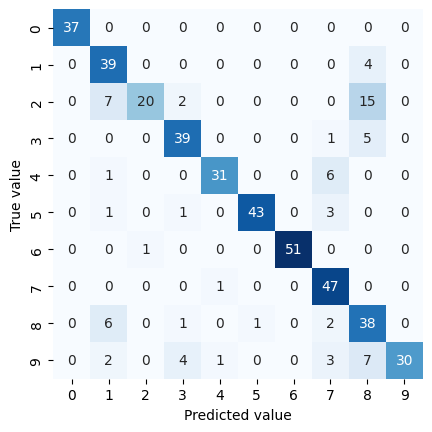

In [13]:
from seaborn import heatmap
heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted value')
plt.ylabel('True value');

## Model Validation

Above, we assessed model accuracy by forming predictions on the test set, and comparing them to the true values.

We could alternatively just form predictions on our training data, and assess their accuracy:

In [14]:
y_predicted_train = model.predict(Xtrain)

Compute the fraction of correctly labeled points in the training data:

In [15]:
accuracy_score(ytrain, y_predicted_train)

0.8574610244988864

The training sample accuracy score is higher than the test sample accuracy score.
This is typical: Using the same data for training and validation over-estimates performance.

Flip the role of training and test set to get two estimates of accuracy:

In [16]:
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.844097995545657, 0.8342602892102335)

Use the `crossval` function to do this for us automatically, for more splits:

In [17]:
cross_val_score(model, X, y, cv=5)

array([0.78055556, 0.78333333, 0.79387187, 0.8718663 , 0.80501393])

We can do as many folds as data points.  This statistically optimal, but computationally more demanding:

In [18]:
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 0., ..., 1., 1., 1.])

The average performance is the mean of these:

In [19]:
scores.mean()

0.8408458542014469

## Linear regression with regularization

Generate new data, for illustration:

In [20]:
rng = np.random.RandomState(2)
x = 10 * rng.rand(200)
y = np.sin(x) + rng.randn(200)
X = x[:, np.newaxis]

Generate spline features, with 20 knots, which we use for regressions below.

In [21]:
features = SplineTransformer(degree=2, n_knots=20) 
X = features.fit_transform(x[:, None])

In [22]:
X[:3]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.2859855 , 0.68431665,
        0.02969786, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.21978553, 0.72343049, 0.05678398, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.15939406, 0.74582513, 0.09478081, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

Running a linear regression, using these spline features

In [23]:
OLS_model = LinearRegression()
OLS_model.fit(X, y)

LinearRegression()

Plot the fit from this regression.

In [24]:
xfit = np.linspace(0, 10, 1000)
Xfit = features.fit_transform(xfit[:, None])
yfit = OLS_model.predict(Xfit)

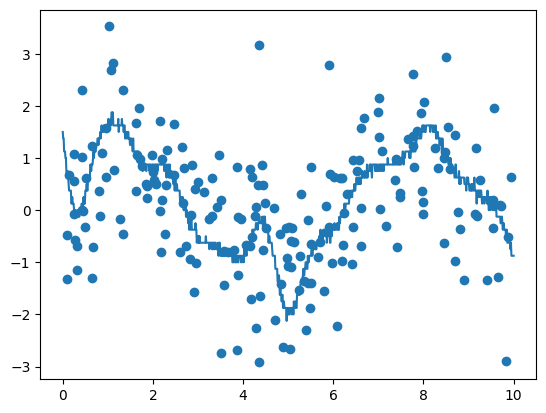

In [25]:
plt.scatter(x, y)
plt.plot(xfit, yfit);

This does not look like a great model. We overfit the data.

One way to solve this problem is regularization.

A simple way to regularize is *Ridge regression*, where we minimize the OLS objective, plus a penalty term:

$\hat{\beta} = argmin_{\beta} \sum_i \|Y_i - X_i \beta\|^2 + \alpha \|\beta\|^2$

In [26]:
Ridge_model = Ridge(alpha=10)
Ridge_model.fit(X, y)
yfit = Ridge_model.predict(Xfit)

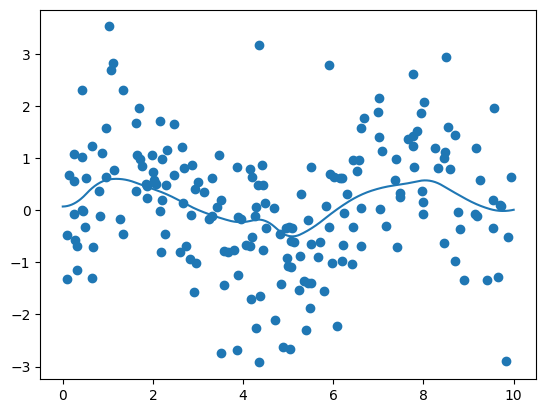

In [27]:
plt.scatter(x, y)
plt.plot(xfit, yfit);

An alternative to Ridge is Lasso, wich uses a penalty based on the absolute value of coefficients:

$\hat{\beta} = argmin_{\beta} \sum_i \|Y_i - X_i \beta\|^2 + \alpha \sum_j |\beta_j|$

In [28]:
from sklearn.linear_model import Lasso
Lasso_model = Lasso(alpha=.02)
Lasso_model.fit(X, y)
yfit = Lasso_model.predict(Xfit)

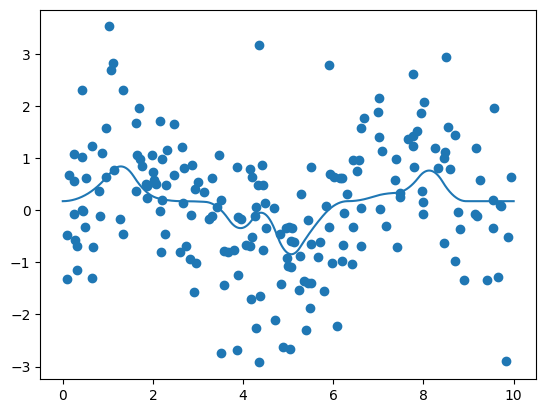

In [29]:
plt.scatter(x, y)
plt.plot(xfit, yfit);

## Model selection

The penalty parameter $\alpha$, for both Ridge and Lasso, determines how we trade off variance and bias:
- A large penalty leads to estimators with small variance, but large bias. 
Such estimators are said to underfit the data.
- A small penalty leads to estimators with large variance, but small bias.
Such estimators are said to overfit the data.

We can use the penalty parameter which gives the best predictive performance on validation data.

Calculate how cross-validated mean squared error depends on $\alpha$, for Ridge regression in our data:

In [30]:
ridge_model = Ridge()
param_range = np.linspace(.2, 10, 50)

train_scores, test_scores = validation_curve(
    ridge_model, X, y, 
    param_name="alpha", param_range=param_range, 
    cv=10, scoring="neg_mean_squared_error"
)

# Average across folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

Plot the resulting validation curve:

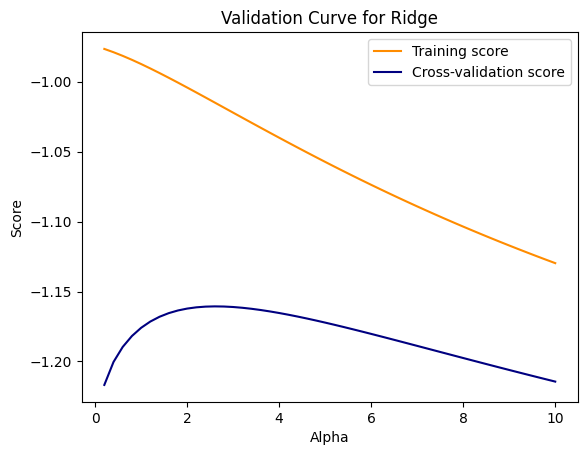

In [31]:
# Plot the validation curve
plt.figure()
plt.title("Validation Curve for Ridge")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
plt.legend(loc="best")

We see a number of interesting things in this picture:

1. The training score over-estimates performance, relative to the (unbiased) cross-validation score.
2. A larger penalty (more regularization) always makes *in-sample* performance (the training score) worse.
3. A larger penalty first  increases, then decreases the cross-validation score.  
   The optimal penalty is somewhere in the middle.

We can automatically search for the best penalty parameter using grid search:

In [32]:
grid = GridSearchCV(ridge_model, {'alpha': param_range}, cv=10)
grid.fit(X, y)
grid.best_params_

{'alpha': 3.2}

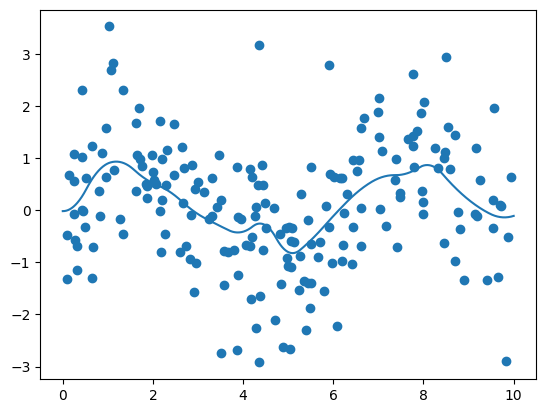

In [33]:
bestmodel = grid.best_estimator_
yfit = bestmodel.predict(Xfit)
plt.scatter(x, y)
plt.plot(xfit, yfit);

Do the same exercise for Lasso regression.

In [34]:
lasso_model = Lasso()
param_range = np.linspace(.00125, .05, 40)

train_scores, test_scores = validation_curve(
    lasso_model, X, y, 
    param_name="alpha", param_range=param_range, 
    cv=10, scoring="neg_mean_squared_error"
)

# Average across folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

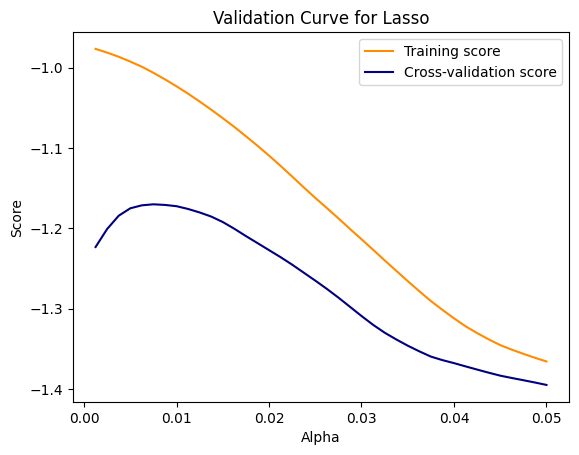

In [35]:
# Plot the validation curve
plt.figure()
plt.title("Validation Curve for Lasso")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
plt.legend(loc="best")

In [36]:
grid = GridSearchCV(lasso_model, {'alpha': param_range}, cv=10)
grid.fit(X, y)
grid.best_params_

{'alpha': 0.01}

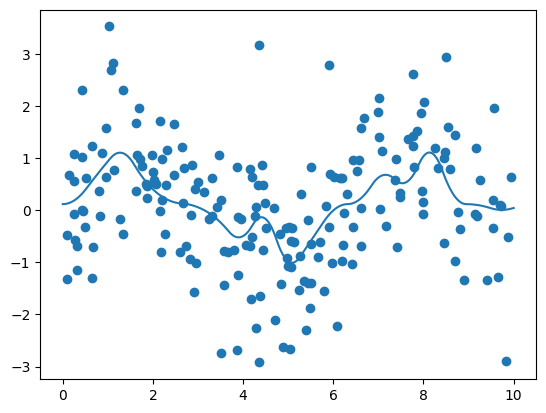

In [37]:
bestmodel = grid.best_estimator_
yfit = bestmodel.predict(Xfit)
plt.scatter(x, y)
plt.plot(xfit, yfit);

## Summary

Let us summarize a typical work flow for supervised learning:

1. Transform your input data, to create a matrix of features `X` and a vector of outcomes `Y`.
2. Select a model, e.g. `GaussianNB` or `Ridge`. Such models typically have hyper-parameters that determine the degree of regularization or model complexity, which trade off variance and bias.
3. Evaluate out-of sample performance using sample splitting or cross-validation, using `cross_val_score`.
4. Choose hyper-parameters by doing a grid search to minimize cross-validated prediction loss, using `GridSearchCV`.
5. Then use the estimator with optimized hyperparameters for predictions on new observations.

We will discuss in the next part of class when and why this approach works.
